<a href="https://colab.research.google.com/github/Falconwatch/MarketKing/blob/feature%2Fpredict_high/High_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В этом ноутбуке развивается предсказатель высшей точки. Его цель - предсказывать, что мы находимя в локлаьном максимуме - цены выше на заданном горизонте в будущем не будет

In [2]:
#!pip install yfinance

In [3]:
from numpy.core.numeric import isclose
import yfinance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import isclose
%matplotlib inline

In [5]:
from methods import load_data

# Готовим данные

In [6]:
stocks = load_data("sber.me", period_start="2021-01-01")
stocks.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2021-01-04,258.583806,260.400767,256.578546,258.593201,41277720
2021-01-05,258.583802,259.553478,254.450891,257.501129,42179430
2021-01-06,259.779408,259.779408,255.712404,257.887115,36784175
2021-01-08,257.887115,257.887115,257.887115,257.887115,0
2021-01-11,266.294115,275.793213,263.112091,271.650879,108435431


In [12]:
train_size = int(stocks.shape[0]*2/3)
stocks_test = stocks[train_size:]
stocks = stocks[:train_size]

## Размечаем таргет

In [23]:
def mark_target(prices, window=10, how="high"):
  """Размечаем фактические точки лоу и хай"""
  if how == "high":
    facts = prices.rolling(window=window, center=True).max()
  elif how == "low":
    facts = prices.rolling(window=window, center=True).min()

  targets = np.zeros_like(prices)
  targets[prices==facts]=1
  return targets

def mark_data_targets(data):
  lows = mark_target(data["Close"], window=5, how="low")
  data["lows"] = lows
  peaks = mark_target(data["Close"], window=5)
  data["peaks"] = peaks

mark_data_targets(stocks)
mark_data_targets(stocks_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


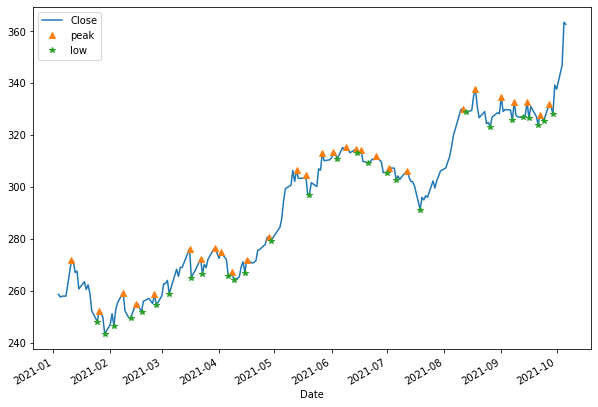

In [24]:
stocks["Close"].plot(figsize=[10,7])
stocks.loc[stocks["peaks"]==1, "Close"].plot(style="^", label="peak")
stocks.loc[stocks["lows"]==1, "Close"].plot(style="*", label="low")
plt.legend()

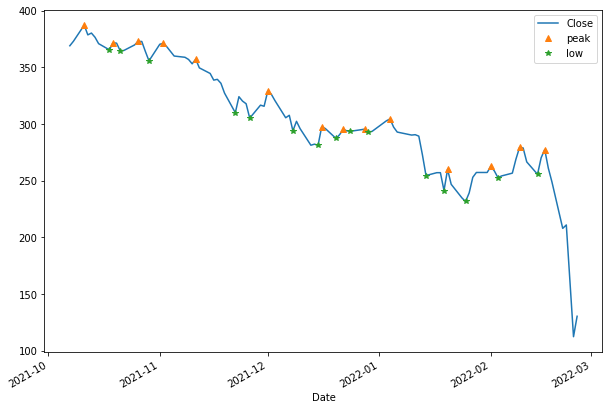

In [25]:
stocks_test["Close"].plot(figsize=[10,7])
stocks_test.loc[stocks_test["peaks"]==1, "Close"].plot(style="^", label="peak")
stocks_test.loc[stocks_test["lows"]==1, "Close"].plot(style="*", label="low")
plt.legend()

# Обучение

## Расчитываем скользящие средние (СС)

In [36]:
def create_ma(prices, ma_steps=[5,10,15,20]):
  """Фозвращает датафрейм с ценой и её скользящими средними заданной ширины"""
  result=pd.DataFrame()
  result["price"] = prices
  for ma_step in ma_steps:
    ma = prices.rolling(ma_step).mean()
    result["ma_{}".format(ma_step)] = ma
  return result

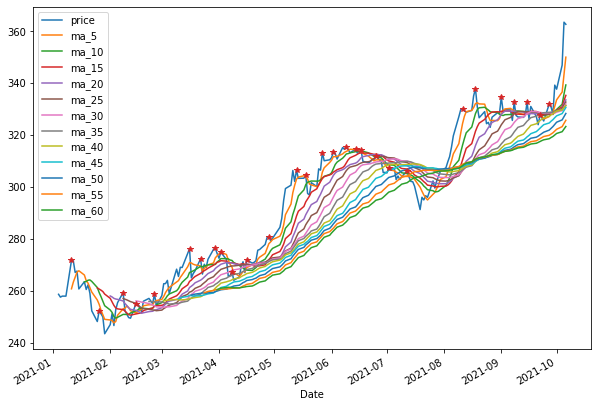

In [30]:
stocks_ma = create_ma(stocks["Close"], ma_steps=np.arange(5, 61, 5))
stocks_test_ma = create_ma(stocks_test["Close"], ma_steps=np.arange(5, 61, 5))

stocks_ma.plot(figsize=[10,7])
stocks.loc[stocks["peaks"]==1, "Close"].plot(style="*")

## Отловим сигналы по СС

In [31]:
def find_sell_signals(short_ma, long_ma):
  """ищем сигнал "продавать" - короткое МА пересекает длинное МА сверху"""
  short_higher = short_ma.shift(-1) > long_ma.shift(-1) #короткое было выше
  short_lower = short_ma.shift(1) < long_ma.shift(1) #короткое стало ниже

  sell_signals = short_higher & short_lower
  return sell_signals

def find_buy_signals(short_ma, long_ma):
  """ищем сигнал "продавать" - короткое МА пересекает длинное МА снизу"""
  short_lower = short_ma.shift(-1) < long_ma.shift(-1) #короткое было выше
  short_higher = short_ma.shift(1) > long_ma.shift(1) #короткое стало ниже

  buy_signals = short_higher & short_lower
  return buy_signals

In [43]:
def form_signals(data, data_ma):
  sell_signals = pd.DataFrame()
  buy_signals = pd.DataFrame()

  for i in range(1, len(data_ma.columns)):
    short_ma_name = data_ma.columns[i]
    short_ma = data_ma[short_ma_name]
    for j in range(i, len(data_ma.columns)):
      long_ma_name = data_ma.columns[j]
      long_ma = data_ma[long_ma_name]

      sell_signals_name = "{0}_{1}_sell_signal".format(short_ma_name, long_ma_name)
      sell_signals[sell_signals_name] = find_sell_signals(short_ma, long_ma)

      buy_signals_name = "{0}_{1}_buy_signal".format(short_ma_name, long_ma_name)
      buy_signals[buy_signals_name] = find_buy_signals(short_ma, long_ma)

  sell_signals= sell_signals.copy().astype(int)
  buy_signals= buy_signals.copy().astype(int)

  return sell_signals, buy_signals

In [45]:
sell_signals, buy_signals = form_signals(stocks, stocks_ma)

In [46]:
test_sell_signals, test_buy_signals = form_signals(stocks_test, stocks_test_ma)

## Валидатор стратегии

In [37]:
def validate (stocks, start_money = 1000, start_eq=0, verbose=0):
  def _print(txt, priority):
    if priority<verbose:
      print(txt)

  #На старте есть 100 уе, играем по стратегии: при сигнале на покупку покупаем всё, при сигнале на продажу - продаём всё
  money_hist = list()

  money = start_money
  eq = start_eq
  _print("Денег в начале стратегии: {0}".format(money), 0)

  for row in stocks.iterrows():
    r = row[1]

    if ~np.isnan(r["buy_signal"]): #сигнал на покупку
      if money>0: #деньги есть
        price = r["price"]
        available_eq = np.floor(money/price)
        eq += available_eq
        money-=available_eq*price
        _print("{0}: Покупаем {1}  по цене {2}, остаток средств: {3}".format(row[0], available_eq, price, money),1)
    if ~np.isnan(r["sell_signal"]): #сигнал на продажу
      if eq>0: #есть что продать
        price = r["price"]
        sell_eq = eq
        eq = 0
        money+=sell_eq*price
        _print("{0}: Продаём {1}  по цене {2}, остаток средств: {3}".format(row[0], sell_eq, price, money), 1)
    #записываем историю нашего благосоятояния
    money_hist.append(money)

    #запоминаем последнюю цену
    last_price = r["price"]

  #фиксим прибыль
  money += last_price * eq 
  eq = 0

  _print("Денег в конце стратегии: {0}".format(money), 0)

  return money_hist, money, eq


## Выбираем какая пара СС лучше предсказывает пик
пока лучшее, что было придумано - количество пропущенных пиков и рпсстояние до них
TODO: придумать адекватную метрики качества обнаружения пиков

In [38]:
#перебираем различные комбинации поиска сигналов на продажу и сигналов на покупку
ss_bs_chose_data = pd.DataFrame()
ss_bs_chose_data["price"] = stocks["Close"] 
ma_results = dict()

for ss_name in sell_signals.columns:
  ss_bs_chose_data["sell_signal"] = np.NaN
  ss_bs_chose_data.loc[sell_signals[ss_name]>0, "sell_signal"] = ss_bs_chose_data.loc[sell_signals[ss_name]>0, "price"]
  
  for bs_name in buy_signals.columns: 
    ss_bs_chose_data["buy_signal"] = np.NaN
    ss_bs_chose_data.loc[buy_signals[bs_name]>0, "buy_signal"] = ss_bs_chose_data.loc[buy_signals[bs_name]>0, "price"] 
    money_hist, money, eq = validate(ss_bs_chose_data, start_money = 10000, verbose=0)
    ma_results[ss_name+"+"+bs_name] = money

In [39]:
ma_results_pd = pd.DataFrame.from_dict(ma_results, orient="index", columns=["result"])
ma_results_pd.sort_values(by="result", ascending=False).head()

,result
ma_35_ma_40_sell_signal+ma_5_ma_20_buy_signal,15419.152588
ma_35_ma_50_sell_signal+ma_5_ma_20_buy_signal,15380.409088
ma_45_ma_50_sell_signal+ma_10_ma_15_buy_signal,15251.534546
ma_30_ma_45_sell_signal+ma_5_ma_20_buy_signal,15155.833099
ma_45_ma_50_sell_signal+ma_5_ma_20_buy_signal,15126.394592


In [40]:
chosen_sell_signals, chosen_buy_signals = ma_results_pd.sort_values(by="result", ascending=False).index.values[0].split("+")

# Применяем выбранные СС

In [41]:
print(chosen_sell_signals)
print(chosen_buy_signals)

ma_35_ma_40_sell_signal
ma_5_ma_20_buy_signal


In [ ]:
def apply_strategy(data, sell_signals, buy_signals, chosen_sell_signals):
  data["sell_signal"] = np.NaN
  data.loc[sell_signals[chosen_sell_signals]>0, "sell_signal"] = data.loc[sell_signals[chosen_sell_signals]>0, "Close"] 

  data["buy_signal"] = np.NaN
  data.loc[buy_signals[chosen_buy_signals]>0, "buy_signal"] = stocks.loc[buy_signals[chosen_buy_signals]>0, "Close"] 

  data["price"] = data["Close"]

In [42]:
stocks["sell_signal"] = np.NaN
stocks.loc[sell_signals[chosen_sell_signals]>0, "sell_signal"] = stocks.loc[sell_signals[chosen_sell_signals]>0, "Close"] 

stocks["buy_signal"] = np.NaN
stocks.loc[buy_signals[chosen_buy_signals]>0, "buy_signal"] = stocks.loc[buy_signals[chosen_buy_signals]>0, "Close"] 

stocks["price"] = stocks["Close"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

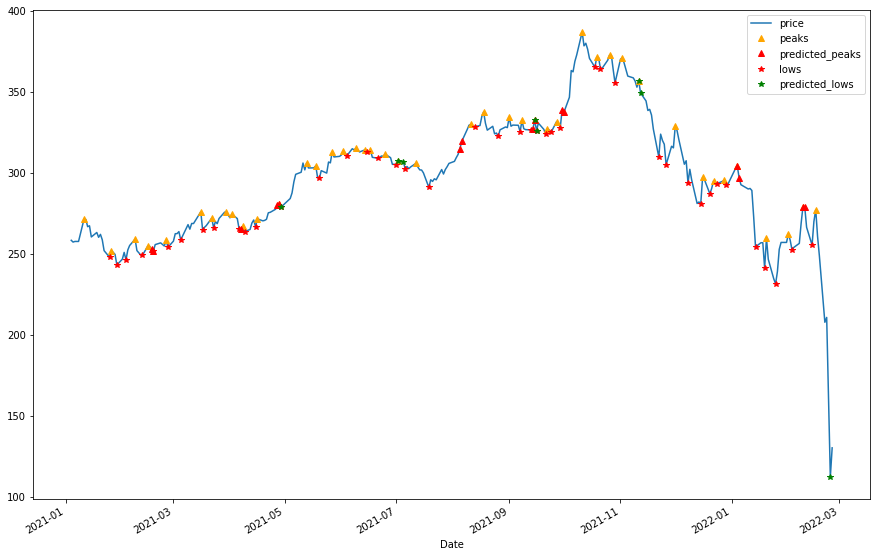

In [ ]:
ax = stocks["price"].plot(figsize=[15,10])
stocks.loc[stocks["peaks"]==1, "Close"].plot(style="^", color = "orange", label = "peaks")
stocks["sell_signal"].plot(style="^", color = "red", label="predicted_peaks")

stocks.loc[stocks["lows"]==1, "Close"].plot(style="*", color = "red", label = "lows")
stocks["buy_signal"].plot(style="*", color = "green", label="predicted_lows")

ax.legend()

# Валидатор стратегии

In [ ]:
money_hist, money, eq = validate(stocks, start_money = 10000, verbose=2)

Денег в начале стратегии: 10000
2021-04-29 00:00:00: Покупаем 35.0  по цене 279.1352844238281, остаток средств: 230.26504516601562
2021-07-02 00:00:00: Покупаем 0.0  по цене 307.260009765625, остаток средств: 230.26504516601562
2021-07-05 00:00:00: Покупаем 0.0  по цене 307.1700134277344, остаток средств: 230.26504516601562
2021-08-05 00:00:00: Продаём 35.0  по цене 315.19000244140625, остаток средств: 11261.915130615234
2021-09-15 00:00:00: Покупаем 33.0  по цене 332.6700134277344, остаток средств: 283.8046875
2021-09-15 00:00:00: Продаём 33.0  по цене 332.6700134277344, остаток средств: 11261.915130615234
2021-09-16 00:00:00: Покупаем 34.0  по цене 326.29998779296875, остаток средств: 167.71554565429688
2021-09-30 00:00:00: Продаём 34.0  по цене 339.1400146484375, остаток средств: 11698.476043701172
2021-11-11 00:00:00: Покупаем 32.0  по цене 357.1000061035156, остаток средств: 271.2758483886719
2021-11-12 00:00:00: Покупаем 0.0  по цене 349.510009765625, остаток средств: 271.2758483

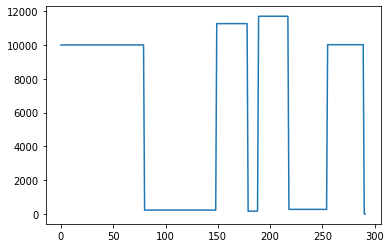

In [ ]:
plt.plot(money_hist)

In [ ]:
money

11617.275848388672

# Изменение цены

In [ ]:
np.zeros()[prices==maxes]

In [ ]:
t[-10:]

In [ ]:
len(t)

In [ ]:
stocks["Close"]